# Find precipitation events

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt

from ros_database.processing.extract_precip_events import find_events
from ros_database.filepath import SURFOBS_HOURLY_PATH
from ros_database.processing.surface import load_station_combined_data
from ros_database.plotting import plot_period_of_record, plot_metdata_histograms, plot_ptype, plot_bar

pd.set_option('display.max_rows', 20)

PTYPES = ['UP','RA','FZRA','SOLID']

In [2]:
hourly = list(SURFOBS_HOURLY_PATH.glob("*.csv"))

In [3]:
df = load_station_combined_data(hourly[0])
df.head()

,station,t2m,d2m,relh,mslp,psurf,p01i,UP,RA,FZRA,SOLID,wspd,drct
datetime,,,,,,,,,,,,,
1988-01-05 14:00:00,PAFM,-7.1,-11.6,70.24,NaN,1017.6,NaN,NaN,NaN,NaN,NaN,3.09,90.0
1988-01-05 15:00:00,PAFM,-9.3,-13.8,69.77,NaN,1017.3,NaN,NaN,NaN,NaN,NaN,3.09,0.0
1988-01-05 16:00:00,PAFM,-11.6,-15.6,72.81,NaN,1017.3,NaN,NaN,NaN,NaN,NaN,2.58,340.0
1988-01-05 17:00:00,PAFM,-11.6,-16.0,69.85,NaN,1017.3,NaN,NaN,NaN,NaN,NaN,2.57,320.1
1988-01-05 18:00:00,PAFM,-11.6,-16.0,69.85,NaN,1016.9,NaN,NaN,NaN,NaN,NaN,2.06,349.9


## Calculate Daily data

In [4]:
nansum = lambda x: np.sum(x) if x.notnull().all() else np.nan
count_ptypes = "sum"

def wind_components(x):
    u = x.wspd * np.sin(np.radians(x.drct))
    v = x.wspd * np.cos(np.radians(x.drct))
    return pd.DataFrame({'u': u, 'v': v})    
    
def wind_polar(x):
    wspd = np.sqrt(x.u**2 + x.v**2)
    drct = np.degrees(np.arctan2(x.v, x.u))
    return pd.DataFrame({'wspd': wspd, 'drct': drct})


dfday = df.resample('D').agg(
    {
        "t2m": "mean",
        "d2m": "mean",
        "psurf": "mean",
        "p01i": nansum,
        "RA": "any",
        "FZRA": "any",
        "UP": "any",
        "SOLID": "any",
    }
)

dfday = dfday.join(wind_polar(wind_components(df).resample('D').mean()))

dfday

,t2m,d2m,psurf,p01i,RA,FZRA,UP,SOLID,wspd,drct
datetime,,,,,,,,,,
1988-01-05,-10.325000,-14.937500,1017.200000,NaN,False,False,False,False,2.012801,90.899857
1988-01-06,-8.711111,-13.600000,1012.533333,NaN,False,False,False,False,2.376410,78.784977
1988-01-07,-6.633333,-11.555556,1010.400000,NaN,False,False,False,False,1.502566,58.245356
1988-01-08,-8.390909,-12.700000,1008.845455,NaN,False,False,False,False,3.234533,71.848459
1988-01-09,-10.280000,-13.580000,1007.500000,NaN,False,False,False,False,2.838491,76.273141
...,...,...,...,...,...,...,...,...,...,...
2023-11-09,-4.579167,-10.345833,990.200000,0.0,False,False,False,True,4.908093,72.386972
2023-11-10,-4.479167,-6.608333,987.591667,0.0,False,False,False,True,3.182511,59.799549
2023-11-11,-10.452174,-12.443478,998.937500,NaN,False,False,False,True,1.038927,98.334687


## Some basic plotting

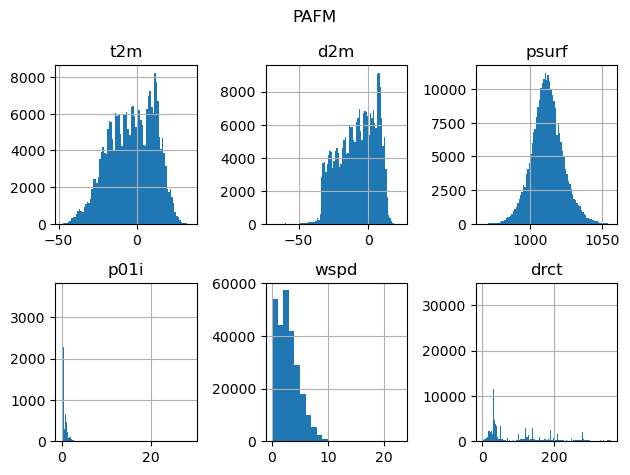

In [5]:
plot_metdata_histograms(df)

plot_line(dfday.t2m, add_axhline=True, title='2m Air Temperature')

CPU times: user 36.7 s, sys: 2.32 s, total: 39.1 s
Wall time: 36.4 s


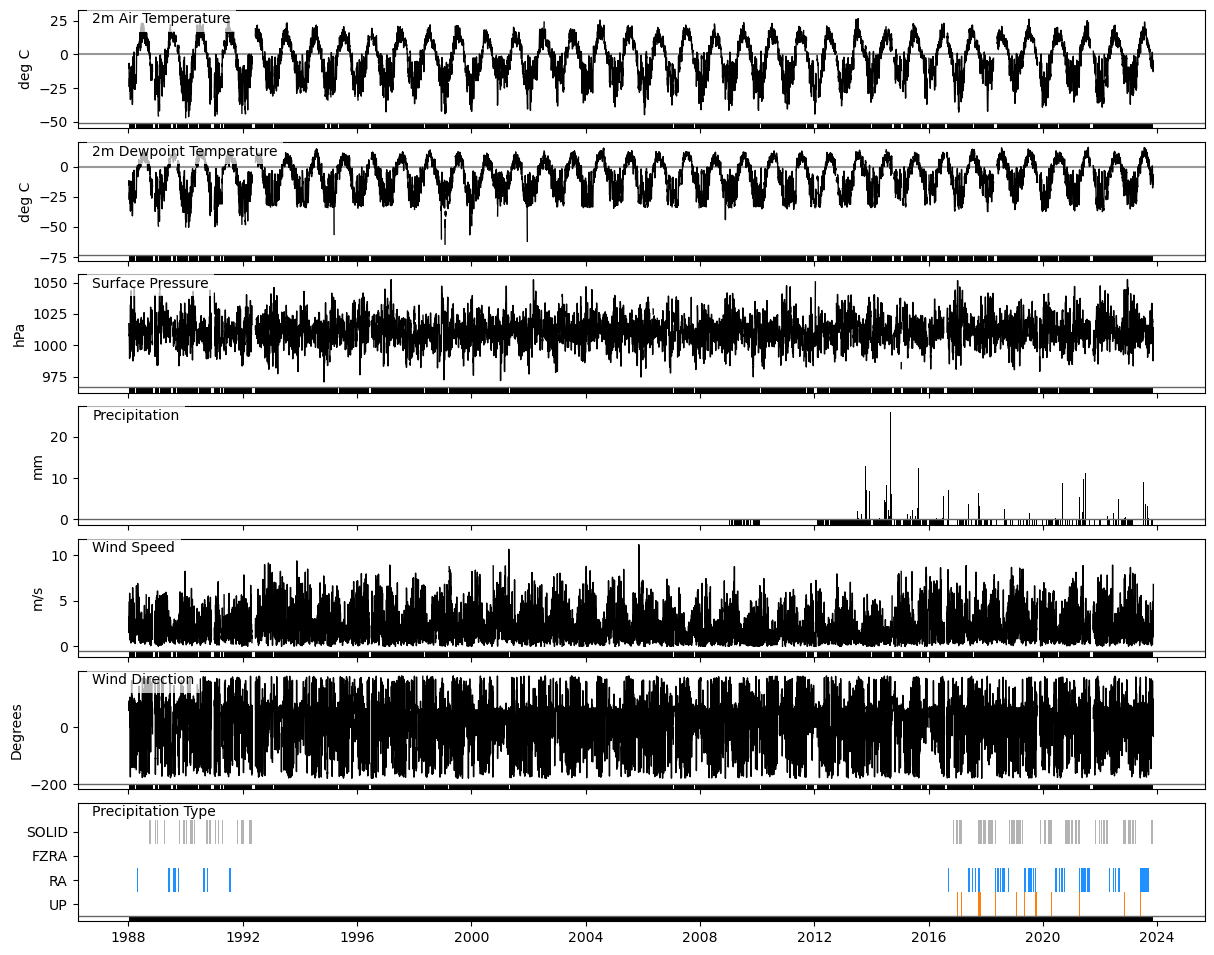

In [6]:
%%time
fig, ax = plot_period_of_record(dfday)


In [17]:
fig, ax = plt.subplots()

width = dfday.index[1] - dfday.index[0]
print(width)
loffset=[1,2,3,4]
for lo, ptype in zip(loffset, PTYPES):
    ax.eventplot(dfday.index[dfday[ptype]], lineoffsets=lo, linewidth=width)

1 days 00:00:00
Error in callback <function _draw_all_if_interactive at 0x7d7b957df920> (for post_execute):


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

<Figure size 640x480 with 1 Axes>

In [ ]:
events = find_events(df)
events

In [ ]:
bins = np.arange(1,72)

fig, ax = plt.subplots(1, 4)
events['duration'].plot(kind='hist', ax=ax[0], bins=bins, title="All")

liquid = (events.RA > 0) | (events.FZRA > 0) & (events.SOLID == 0) & (events.UP == 0)
events[liquid]['duration'].plot(kind='hist', ax=ax[1], bins=bins, title="RA + FZRA", ylabel="")

solid = (events.RA == 0) & (events.FZRA == 0) & (events.SOLID > 0) & (events.UP == 0)
events[solid]['duration'].plot(kind='hist', ax=ax[2], bins=bins, title="Solid")

up_only = (events.RA == 0) & (events.FZRA == 0) & (events.SOLID == 0) & (events.UP > 0)
events[up_only]['duration'].plot(kind='hist', ax=ax[3], bins=bins, title="UP only")


In [ ]:
def is_liquid(df):
    return (df.RA > 0) | (df.FZRA > 0) & (df.SOLID == 0) & (df.UP == 0)

def is_solid(df):
    return (df.RA == 0) & (df.FZRA == 0) & (df.SOLID > 0) & (df.UP == 0)

def is_up(df):
    return (df.RA == 0) & (df.FZRA == 0) & (df.SOLID == 0) & (df.UP > 0)

In [ ]:
# Check liquid
pd.testing.assert_series_equal(is_liquid(test), pd.Series([True, True, False, False]),
                              check_index_type=False,)

pd.testing.assert_series_equal(is_solid(test), pd.Series([False, False, True, False]),
                              check_index_type=False,)

pd.testing.assert_series_equal(is_up(test), pd.Series([False, False, False, True]),
                              check_index_type=False,)

## Plot precipitation type and amount

In [ ]:
import matplotlib.dates as mdates

def make_event_bars(df, y0=-0.05, height=0.05, color='0.7'):
    event_box = []
    for event in df.iterrows():
        x0 = mdates.date2num(event[1].start)
        x1 = mdates.date2num(event[1].end)
        width = x1 - x0
        if event[1].RA:
            color='crimson'
        else:
            color='0.7'
        event_box.append(Rectangle((x0, y0), width, height, facecolor=color, edgecolor=color))
    return PatchCollection(event_box, zorder=0, match_original=True)

In [ ]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

sub_df = df['2023-10-01':]
sub_events = events['2023-10-01':]

fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

width = dt.timedelta(hours=1)
ax[0].bar(sub_df.index, sub_df.p01i, width=width, color='k')
ax[0].add_collection(make_event_bars(sub_events, y0=0., height=0.1))
# [ax[0].axhline(-0.05, xmin=
               
ax[1].plot(sub_df.index, sub_df.t2m)
ax[1].axhline(0., c='0.7', zorder=0)

ax[2].plot(sub_df.index, sub_df.wspd)

In [ ]:
sub_df.drop(['station', 'd2m', 'relh', 'mslp', 'psurf', 'drct'], axis=1)

## Find frequency of reported precipitation

In [ ]:
for ptype in ["UP", "RA", "FZRA", "SOLID"]:
    print(f"{ptype:5s} and measured P:    {(df[ptype] & (df.p01i > 0)).sum()}")
    print(f"{ptype:5s} and no measured P: {(df[ptype] & (df.p01i == 0)).sum()}")

In [ ]:
df.wspd.hist(bins=np.arange(0,22))

In [ ]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
bins = np.arange(0,22)
for i, ptype in enumerate(["UP", "RA", "FZRA", "SOLID"]):
    df[df[ptype] & (df.p01i > 0)].wspd.hist(ax=ax[i], bins=bins, alpha=0.5)
    df[df[ptype] & (df.p01i == 0)].wspd.hist(ax=ax[i], bins=bins, alpha=0.5)
    

In [ ]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
bins = np.arange(0,22)
for i, ptype in enumerate(["UP", "RA", "FZRA", "SOLID"]):
    df[df[ptype] & (df.p01i > 0)].t2m.hist(ax=ax[i], bins=bins, alpha=0.5, label="Measured P")
    df[df[ptype] & (df.p01i == 0)].t2m.hist(ax=ax[i], bins=bins, alpha=0.5, label="No P")
    ax[i].set_title(ptype)
    if i == 3:
        ax[i].legend()

## Find winter period

## Aggregate to daily for analysis

In [ ]:
df.p01i.min()

In [ ]:
df["1988-01-05":"1988-01-05 23"].p01i.sum()

## Load Snow Cover

In [ ]:
snowcover = pd.read_csv("ims.surface_values.stations.csv", index_col=0, parse_dates=True)
snowcover.head()

In [ ]:
freq = lambda x: (x == 4).sum()/x.count()
ptype_freq = lambda x: x.sum()/x.count()

sog_freq = snowcover["PAFM"].groupby(snowcover.index.day_of_year).apply(freq)

In [ ]:
import matplotlib.pyplot as plt

# Calculate 95th percentile temperatures
t2m_95 = dfday.t2m.groupby(dfday.index.day_of_year).quantile(0.95).rolling(window=7, center=True).mean()
p01i_mean = dfday.p01i.where(dfday.p01i > 0).groupby(dfday.index.day_of_year).mean()
ptype_freq = dfday[PTYPES].groupby(dfday.index.day_of_year).apply(lambda x: x.sum() / x.sum().sum())  #sum()

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12,10))

ax[0].scatter(dfday.index.day_of_year, dfday.t2m, s=2, c='0.7', alpha=0.5)
ax[0].plot(t2m_95.index, t2m_95, label="95th Percentile")
ax[0].axhline(0., c='0.4')
ax[0].set_ylabel("deg C")
ax[0].text(0.01, 0.99, "2m Air Temperature", va="top", transform=ax[0].transAxes)

ax[1].bar(p01i_mean.index, p01i_mean, color='k')
ax[1].set_ylabel("mm")
ax[1].text(0.01, 0.99, "Precipitation", va="top", transform=ax[1].transAxes)

bottom = 0
colors = ['tab:orange', 'dodgerblue', 'lightskyblue', '0.7'] 
for pf, color in zip(ptype_freq, colors):
    ax[2].bar(ptype_freq.index, ptype_freq[pf], label=pf, bottom=bottom, color=color)
    bottom += ptype_freq[pf]
# ax[2].plot(up_freq.index, up_freq, label="UP")
# ax[2].plot(fzra_freq.index, fzra_freq, label="FZRA")
# ax[2].plot(solid_freq.index, solid_freq, label="SOLID")
ax[2].set_ylabel("Frequency")
ax[2].text(0.01, 0.99, "Precipitation Type", va="top", transform=ax[2].transAxes)
ax[2].legend()

ax[3].fill_between(sog_freq.index, sog_freq, color='0.7')
ylim = ax[3].get_ylim()
ax[3].set_ylim(0., 1.)
ax[3].set_ylabel("Frequency")
ax[3].text(0.01, 0.01, "Snow on Ground", va="bottom", transform=ax[3].transAxes)
ax[3].set_xlim(0.,366.)

# Make xticks and labels
monticks, monlabels = zip(*[(d.day_of_year, d.month_name()[:3]) 
                          for d in pd.date_range('2024-01-01', '2025-01-01', freq='MS')])
list(monticks)[-1] = 366
ax[3].set_xticks(monticks, monlabels)

fig.suptitle("PAFM")
plt.subplots_adjust(top=0.95)

fig.savefig("pafm.climatology.png")
# Add months to xaxis
# Add PTYPES